In [566]:
using ComputationalHeatTransfer
using LaTeXStrings
using Revise
using LinearAlgebra
using DifferentialEquations
using Interpolations
using JLD2


cd(dirname(pwd()))
cd("src") 

includet("OneDOHP.jl")
using ..OneDOHP

In [567]:
using Plots
gr()  

Plots.GRBackend()

$ 0 = A_{c} k_{l} \frac{\partial^{2} T}{\partial \chi^{2}} + (T_{w,l} - T) h_{l} P$

$y = T_{w,l} - T$

$y'' = C^{2} y, C = sqrt(\frac{h_{l} P_{l}}{A_{c} k_{l}})$

$y = \tilde{c}_1 \cosh(C \chi) + \tilde{c}_2 \sinh(C \chi)$, hyperbolic functions， $ \chi \in (-C L_{l} / 2, C L_{l} / 2)$

$y(C L_{l} / 2) = y(-C L_{l} / 2)$

$\tilde{c}_2 = 0$

thus $y = \tilde{c}_1 \cosh(C \chi))$


heat rate balance
$ \frac{P L_{v} k_{l}}{\delta_{v}} (T_{v} - T_{w,v}) = \frac{P L_{v} k_{l}}{\delta_{v}} (T_{w,l} - T_{w,v} - \tilde{c}_1 \cosh(C L_{l} / 2))\\
= A_c k_l \frac{\partial T}{\partial \chi}(\chi = -L_{l} / 2) - A_c k_l \frac{\partial T}{\partial \chi}(\chi = L_{l} / 2) \\
=  A_c k_l (y'(C L_{l} / 2) - y'(-C L_{l} / 2)) \\
= 2\tilde{c}_1 A_c C \cosh(C L_{l} / 2)$

$\tilde{c}_1 = \frac{D(T_{w,l} - T_{w,v})}{D \cosh(C L_l/2) + 2C \sinh (C L_l/2)}$

$D = \frac{L_{v} P}{A_c \delta_{v}}$

# Properies

### Earth property

In [568]:
g = 9.8

9.8

### Solid Physical parameters

In [569]:
ρₛ = 2700; # density
cₛ  = 8.97e02; # specific heat
kₛ  = 1.67e02; # heat conductivity
# d = 2e-3;
plate_d = 2e-3;  # plate thickness
params = HeatConductionParameters(ρₛ ,cₛ ,kₛ ,thickness=plate_d)

HeatConductionParameters(2700.0, 897.0, 167.0, 6.895412692514142e-5, 0.002)

### Fluid Physical parameters

In [570]:
fluid_type = "butane"
Tᵥ = 291.0

291.0

In [571]:
CoolProp.PropsSI("CONDUCTIVITY","T",Tᵥ,"Q",0.0,fluid_type)

0.10768858457917865

In [572]:
Cpₗ = CoolProp.PropsSI("CPMASS","T",Tᵥ,"Q",0.0,fluid_type)
ρₗ  = CoolProp.PropsSI("D","T",Tᵥ,"Q",0.0,fluid_type)
μₗ  = CoolProp.PropsSI("V","T",Tᵥ,"Q",0.0,fluid_type)
hₗ = CoolProp.PropsSI("H","T",Tᵥ,"Q",0.0,fluid_type)
kₗ = CoolProp.PropsSI("CONDUCTIVITY","T",Tᵥ,"Q",0.0,fluid_type)
Prₗ = CoolProp.PropsSI("PRANDTL","T",Tᵥ,"Q",0.0,fluid_type)

Cpᵥ = CoolProp.PropsSI("CPMASS","T",Tᵥ,"Q",1.0,fluid_type)
ρᵥ  = CoolProp.PropsSI("D","T",Tᵥ,"Q",1.0,fluid_type)
μᵥ  = CoolProp.PropsSI("V","T",Tᵥ,"Q",1.0,fluid_type);
hᵥ = CoolProp.PropsSI("H","T",Tᵥ,"Q",1.0,fluid_type)
kᵥ = CoolProp.PropsSI("CONDUCTIVITY","T",Tᵥ,"Q",1.0,fluid_type)
Prᵥ = CoolProp.PropsSI("PRANDTL","T",Tᵥ,"Q",1.0,fluid_type)

σ = CoolProp.PropsSI("I","T",Tᵥ,"Q",0.0,fluid_type)
P = CoolProp.PropsSI("P","T",Tᵥ,"Q",0.0,fluid_type)
R = CoolProp.PropsSI("GAS_CONSTANT","T",Tᵥ,"Q",1.0,fluid_type)
M = CoolProp.PropsSI("M","T",Tᵥ,"Q",1.0,fluid_type)
Rkg = R/M

# Cpₗ = Cpₗ*1e-4

αₗ = kₗ/ρₗ/Cpₗ
# αₗ = αₗ*1e4

νₗ = μₗ/ρₗ
νᵥ = μᵥ/ρᵥ;
hₗᵥ = hᵥ-hₗ;

# Plate Conduction

### Geometry parameters

In [573]:
Lx = 0.1524; # plate size x
Ly = 0.0648; # plate size y

In [574]:
xlim = (-Lx/2,Lx/2) .*1.0
ylim = (-Ly/2,Ly/2) .*1.0
Δx, Δt = setstepsizes(params.α,gridPe=8.0,fourier=0.3)

(0.0005516330154011314, 0.001323919236962715)

### Set up the evaporator and condenser

In [575]:
inch = 2.54e-2;

In [576]:
power = 40 *0 #watts
total_heater_area = 2.0inch*2.0inch;

In [577]:
qe = power/total_heater_area
hc = 1500.0 * 0
Tc = Tᵥ

291.0

In [578]:
eb1 = Rectangle(0.5inch,1.0inch,1.5*Δx)
Tfe = RigidTransform((0.7inch,-0.0),0.0)
Tfe(eb1)

eb2 = Rectangle(0.5inch,1.0inch,1.5*Δx)
Tfe = RigidTransform((-0.7inch,-0.0),0.0)
Tfe(eb2)

cb1 = Rectangle(0.5inch*0.9,Ly*0.9/2,1.5*Δx)
Tfc = RigidTransform((-2.5inch,-0.0),0.0)
Tfc(cb1)

cb2 = Rectangle(0.5inch*0.9,Ly*0.9/2,1.5*Δx)
Tfc = RigidTransform((2.5inch,-0.0),0.0)
Tfc(cb2)

eparams1 = PrescribedHeatFluxRegion(qe,eb1);
eparams2 = PrescribedHeatFluxRegion(qe,eb2);
cparams1 = PrescribedHeatModelRegion(hc,Tc,cb1);
cparams2 = PrescribedHeatModelRegion(hc,Tc,cb2);

### Set up the OHP

In [579]:
ds = 1.5Δx
nturn = 16
width_ohp = 46.25*1e-3
length_ohp = 133.83*1e-3
gap = plate_d
pitch = width_ohp/(2*nturn+1)
x0, y0 = length_ohp/2, width_ohp/2

# x, y, xf, yf = ComputationalHeatTransfer.construct_ohp_curve(nturn,pitch,length_ohp,gap,ds,x0,y0,false,false,3pi/2)
one_loop_gap = 1e-2
x, y, xf, yf = construct_oneloop_curve(0,0,ds,length_ohp,one_loop_gap,pi/2)


ohp = BasicBody(x,y)

Basic pointwise-specified body with 362 points
   Current position: (0.0,0.0)
   Current angle (rad): 0.0


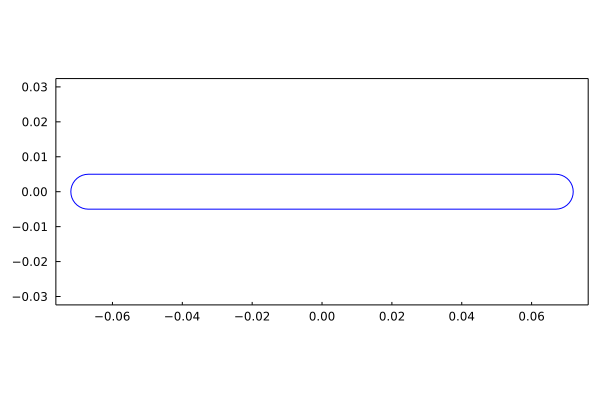

In [580]:
plot(ohp,fillalpha=0,linecolor=:blue,xlims=xlim,ylims=ylim,framestyle = :box)

In [581]:
ohpgeom = ComputationalHeatTransfer.LineSourceParams(ohp)

LineSourceParams{BasicBody{362,RigidBodyTools.ClosedBody}}(Basic pointwise-specified body with 362 points
   Current position: (0.0,0.0)
   Current angle (rad): 0.0
)

### Create the system

In [582]:
sys = HeatConduction(params,Δx,xlim,ylim,Δt,qline=ohpgeom,qflux=[eparams1,eparams2],qmodel=[cparams1,cparams2])

Unbounded Heat conduction system on a grid of size 280 x 120 and 0 static immersed points


# OHP inner part

### Tube geometries

In [583]:
tube_d = 1e-3; # tube diameter

peri = 4*tube_d # Tube perimeter
Ac = tube_d*tube_d # tube cross-sectional area
peri = Ac
# Ac = peri # tube cross-sectional area
L2D = length_ohp # the actual length of the bended pipe in the real world
L = (sys.qline[1].arccoord[1] + sys.qline[1].arccoord[end])  # total length of the pipe when streched to a 1D pipe (an approximate here)
angle = 0*pi/2 # inclination angle 
closedornot = true

true

In [584]:
tube = Tube(tube_d,peri,Ac,L,L2D,angle,g,closedornot);

### Liquid

In [585]:
Nu = 0.999999
Hₗ = kₗ/tube_d * Nu # Nusselt number 4.36

107.68847689059407

In [586]:
# X0,realratio = randomXp(L,numofslugs=60,chargeratio=0.45)
X0 = [(L2D/2,L/2+L2D/2)]

dXdt0_l = zeros(length(X0))
dXdt0_r = zeros(length(X0))
dXdt0 = map(tuple,dXdt0_l,dXdt0_r)

1-element Array{Tuple{Float64,Float64},1}:
 (0.0, 0.0)

In [587]:
# construct liquids
N=numpts(ohp)
Xarrays,θarrays = constructXarrays(X0,N,Tᵥ,L);

In [588]:
liquids=Liquid(Hₗ,ρₗ,Cpₗ,αₗ,μₗ,X0,dXdt0,Xarrays,θarrays);

### Vapor

In [589]:
δ

1-element Array{Float64,1}:
 0.001

In [590]:
P = 0*zeros(length(X0)) .+ TtoP(Tᵥ);
δ = 0*zeros(length(X0)) .+ tube_d;
# δ = 0*zeros(length(X0)) .+ 2.78E-02;
vapors=Vapor(kₗ,P,δ);

### Wall

nucleate boiling sites

In [591]:
ΔTthres = 100.0; # superheat threshold

    nucleatenum = 256
    Xstations = sort(rand(nucleatenum).*L);
#     Xstations = LinRange(0.0,L-L/nucleatenum,nucleatenum)
#     boilingΔt = 0.05

In [592]:
Xwallarray,θwallarray = constructXarrays(sys.qline[1].arccoord,L,Tᵥ);
θwallarray .= Tᵥ

wall = Wall(ΔTthres,Xstations,Xwallarray,θwallarray);

In [593]:
sys0_nomapping = PHPSystem_nomapping(tube,liquids,vapors,wall);
θ_interp_walltoliquid, θ_interp_liquidtowall, H_interp_liquidtowall, P_interp_liquidtowall = sys_interpolation(sys0_nomapping)
mapping = Mapping(θ_interp_walltoliquid, θ_interp_liquidtowall, H_interp_liquidtowall, P_interp_liquidtowall);

In [594]:
sys0 = PHPSystem(tube,liquids,vapors,wall,mapping);

### construct state vector U

In [595]:
Lvaporplug = XptoLvaporplug(X0,sys0.tube.L,sys0.tube.closedornot)
M = PtoD(P) .* Lvaporplug .* Ac
# M = P.^(1/γ).* Lvaporplug


u=[XMδtovec(X0,dXdt0,M,δ); liquidθtovec(sys0.liquid.θarrays)];

In [596]:
cb_boiling =  DiscreteCallback(boiling_condition,boiling_affect!)
# cb_boiling =  PeriodicCallback(boiling_affect!,0.01*t_to_nondi_t)
# cb_merging =  DiscreteCallback(merging_condition,merging_affect!)

# cbst = CallbackSet(cb_boiling,cb_merging);
cbst = CallbackSet(cb_boiling);

# combine inner tube and plate together

In [597]:
tspan = (0.0, 100000.0);
dt_record = tspan[2] /20;

tstep=1e0

N_iter = 1
# tstep_plate = tstep/N_iter
# dt_record = tstep

1

In [598]:
ΔT = -1.0 #[K]

-1.0

In [599]:
u0 = newstate(sys)
integrator_plate = init(u0,tspan,sys)
# Tplate = temperature(integrator_plate);
temperature(integrator_plate) .= Tᵥ;
temperature(integrator_plate)[1:139,:]  .=  Tᵥ + ΔT;

In [600]:
p = sys0
u=[XMδtovec(X0,dXdt0,M,δ); liquidθtovec(sys0.liquid.θarrays)];
prob = ODEProblem(ODE_innertube, u, tspan, p)
integrator_tube = init(prob, RK4(),save_everystep=false, dt=tstep, callback=cbst);

In [601]:
plate_hist = []
tube_hist  = []

currentsys = integrator_tube.p
currentsys = getcurrentsys(integrator_tube.u,currentsys);

currentsys.wall.θarray = temperature_linesource(integrator_plate)
currentsys = getcurrentsys(integrator_tube.u,currentsys)
integrator_tube.p = currentsys
qtmp = sys_to_heatflux(currentsys)
set_linesource_strength!(sys,qtmp);

In [602]:
push!(plate_hist,deepcopy(integrator_plate)); 
push!(tube_hist,deepcopy(integrator_tube));

In [603]:

@time for t in tspan[1]:tstep:tspan[2]
    
    # reinitialize the integrator_tube to avoid some mysterious problems
    prob = ODEProblem(ODE_innertube, deepcopy(integrator_tube.u), (integrator_plate.t-tstep,integrator_plate.t), currentsys)
    integrator_tube = init(prob, RK4(), callback=cbst, dt=tstep);
    step!(integrator_tube,tstep,true);
    
    
      for j in 1:N_iter
        currentsys.wall.θarray = temperature_linesource(integrator_plate)
        currentsys = getcurrentsys(integrator_tube.u,currentsys)

        qtmp = sys_to_heatflux(currentsys)
        set_linesource_strength!(sys,qtmp)


#      ADI_timemarching!(temperature(integrator_plate),sys,tstep)
    end
    integrator_plate.t += tstep
    

    if (mod(integrator_plate.t,dt_record) < 1e-6) || (mod(-integrator_plate.t,dt_record) < 1e-6)
        push!(plate_hist,deepcopy(integrator_plate)); 
        push!(tube_hist,deepcopy(integrator_tube));
        println(integrator_plate.t)
    end
    
end

5000.0
10000.0
15000.0
20000.0
25000.0
30000.0
35000.0
40000.0
45000.0
50000.0
55000.0
60000.0
65000.0
70000.0
75000.0
80000.0
85000.0
90000.0
95000.0
100000.0
258.469104 seconds (587.09 M allocations: 156.748 GiB, 11.36% gc time)


In [604]:
sysfinal = []
for i = 1:length(tube_hist)
    push!(sysfinal, deepcopy(getcurrentsys(tube_hist[i].u,tube_hist[i].p)))
end

In [605]:
x = -Lₗ/2:1e-3:Lₗ/2

y = Tₕ .- c_1 * cosh.(x .* k);

#### blue line is the wall T

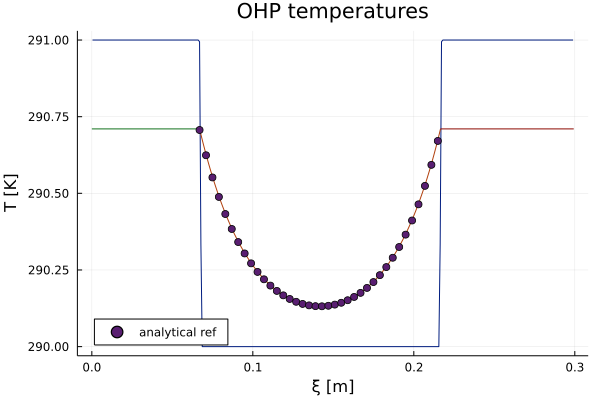

In [653]:
# @gif for ii=1:length(sysfinal)
plot(sysfinal[end],plottype="T",label="")
scatter!((x .+ L2D .+ (L/2-L2D)/2)[1:4:end],y[1:4:end],ylabel="T [K]",xlabel="ξ [m]",legend=:bottomleft,label="analytical ref")
# end

In [607]:
aa = PtoT(sysfinal[end].vapor.P)[1]

290.7101254007029

In [608]:
bb = maximum(y)

290.70661611748744

In [609]:
aa - bb

0.0035092832154646203

In [610]:
Tᵥ

291.0

In [611]:
aa-Tᵥ

-0.289874599297093

In [612]:
ΔT

-1.0

In [613]:
norm((aa - bb)/ΔT)

0.0035092832154646203

In [614]:

# norm((aa - bb)/ΔT)
# 100000 6ds

# 0.012061327009519118

In [615]:
# norm((aa - bb)/ΔT)
# 100000 3ds

# 0.006611818521889745

In [616]:
# norm((aa - bb)/ΔT)
# 200000

# 0.003500281323113086

In [617]:
# norm((aa - bb)/ΔT)
# 100000

# 0.003509174638566037

In [618]:
# norm((aa - bb)/ΔT)
# 50000

# 0.004944652454807138

┌ Info: Saved animation to 
│   fn = C:\Users\liyux\Documents\GitHub\ComputationalHeatTransfer.jl\src\tmp.gif
└ @ Plots C:\Users\liyux\.julia\packages\Plots\LSKOd\src\animation.jl:114


Plots.AnimatedGif("C:\\Users\\liyux\\Documents\\GitHub\\ComputationalHeatTransfer.jl\\src\\tmp.gif")
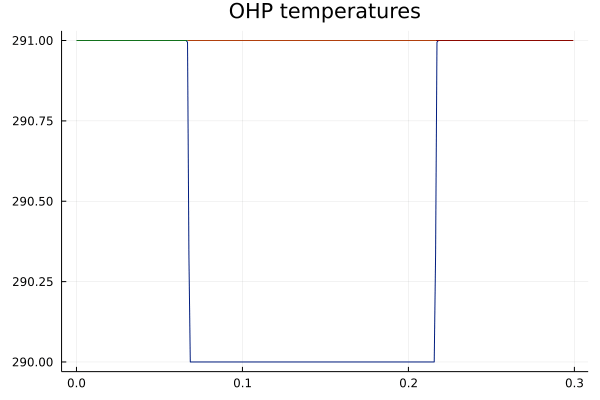

In [619]:
@gif for ii=1:length(sysfinal)
     plot(sysfinal[ii],plottype="T")
end

# plot the OHP

In [620]:
err1 = 0.003509174638566037
err2 = 0.006611818521889745
err4 = 0.012061327009519118

0.012061327009519118

In [621]:
Δx

0.0005516330154011314

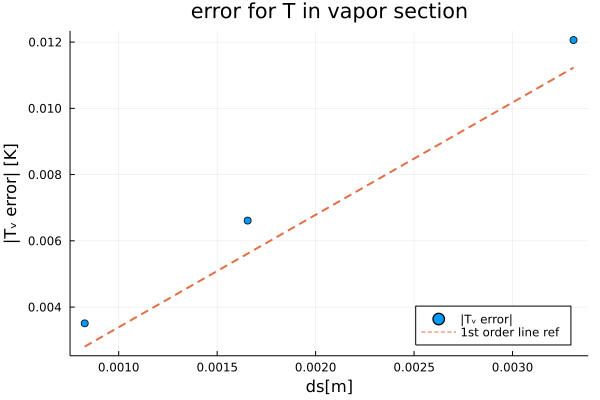

In [655]:
scatter([1.5Δx,1.5Δx*2,1.5Δx*4],[err1,err2,err4],xlabel="ds[m]",ylabel="|Tᵥ error| [K]",legend=:bottomright,linewidth=2.0,markershape=:auto,label="|Tᵥ error|",title="error for T in vapor section")
plot!([1.5Δx,1.5Δx*4],[err1,err1*4] .* 0.8,linestyle=:dash,linewidth=2.0,label="1st order line ref")

┌ Info: Saved animation to 
│   fn = C:\Users\liyux\Documents\GitHub\ComputationalHeatTransfer.jl\src\tmp.gif
└ @ Plots C:\Users\liyux\.julia\packages\Plots\LSKOd\src\animation.jl:114


Plots.AnimatedGif("C:\\Users\\liyux\\Documents\\GitHub\\ComputationalHeatTransfer.jl\\src\\tmp.gif")
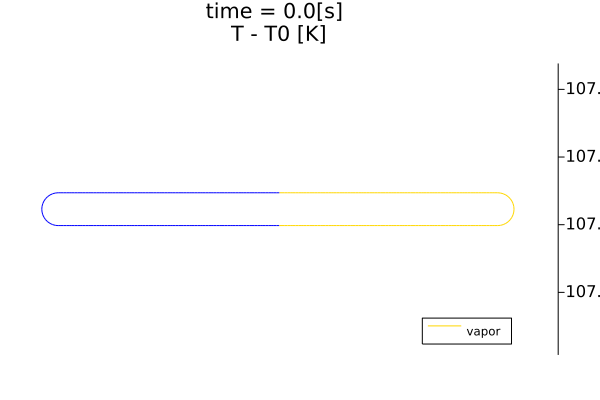

In [647]:
@gif for i=1:1:length(sysfinal)
    Htmp = sys_to_Harray(sysfinal[i])
    plot(ohp,fillalpha=0,linecolor=cgrad([:gold, :blue],rev=true),line_z=Htmp,xlabel="x ",ylabel="y ",title=string("time = ", round(plate_hist[i].t, digits=2), "[s] \n",  "T - T0 [K]"),border=:none,axis=nothing,legend=:bottomright,label="vapor")
end

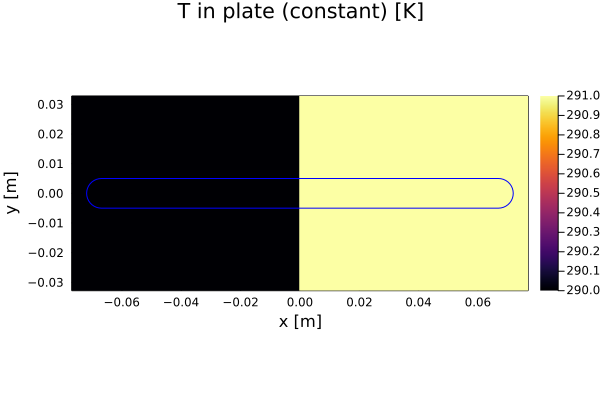

In [648]:
# heatmap(temperature(plate_hist[end]),sys.grid,legend=true,xlabel="x [m]",ylabel="y [m]",clim=(290.0,291.0))
Htmp = sys_to_Harray(sysfinal[end])

heatmap(temperature(plate_hist[end]),sys.grid,legend=true,xlabel="x [m]",ylabel="y [m]",clim=(290.0,291.0))
    plot!(ohp,fillalpha=0,linecolor=:blue,title="T in plate (constant) [K]")